# [LAB 10] 일원분산분석 연습문제



### 준비작업
[1] 패키지 참조

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell


[2] 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

## 연습문제 1 
tree_weight 데이터셋은 소나무 품종별 무게를 조사한 데이터이다. 소나무 품종별로 평균 무게에 차이가 있는지 분석하라.

[0] 데이터 가져오기

In [4]:
tree_weight = load_data('tree_weight')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {tree_weight.shape}")
print(f"열 개수: {tree_weight.shape[1]}")
print(f"행 개수: {tree_weight.shape[0]}")

print("\n===== 타입확인 =====")
print(tree_weight.info())

tree_weight


[data] https://data.hossam.kr/data/lab10_/tree_weight.xlsx
[desc] 소나무 품종별 무게를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (30, 2)
열 개수: 2
행 개수: 30

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  30 non-null     float64
 1   group   30 non-null     object 
dtypes: float64(1), object(1)
memory usage: 612.0+ bytes
None


,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A
5,4.61,A
6,5.17,A
7,4.53,A
8,5.33,A
9,5.14,A


[1] 데이터 분포 확인

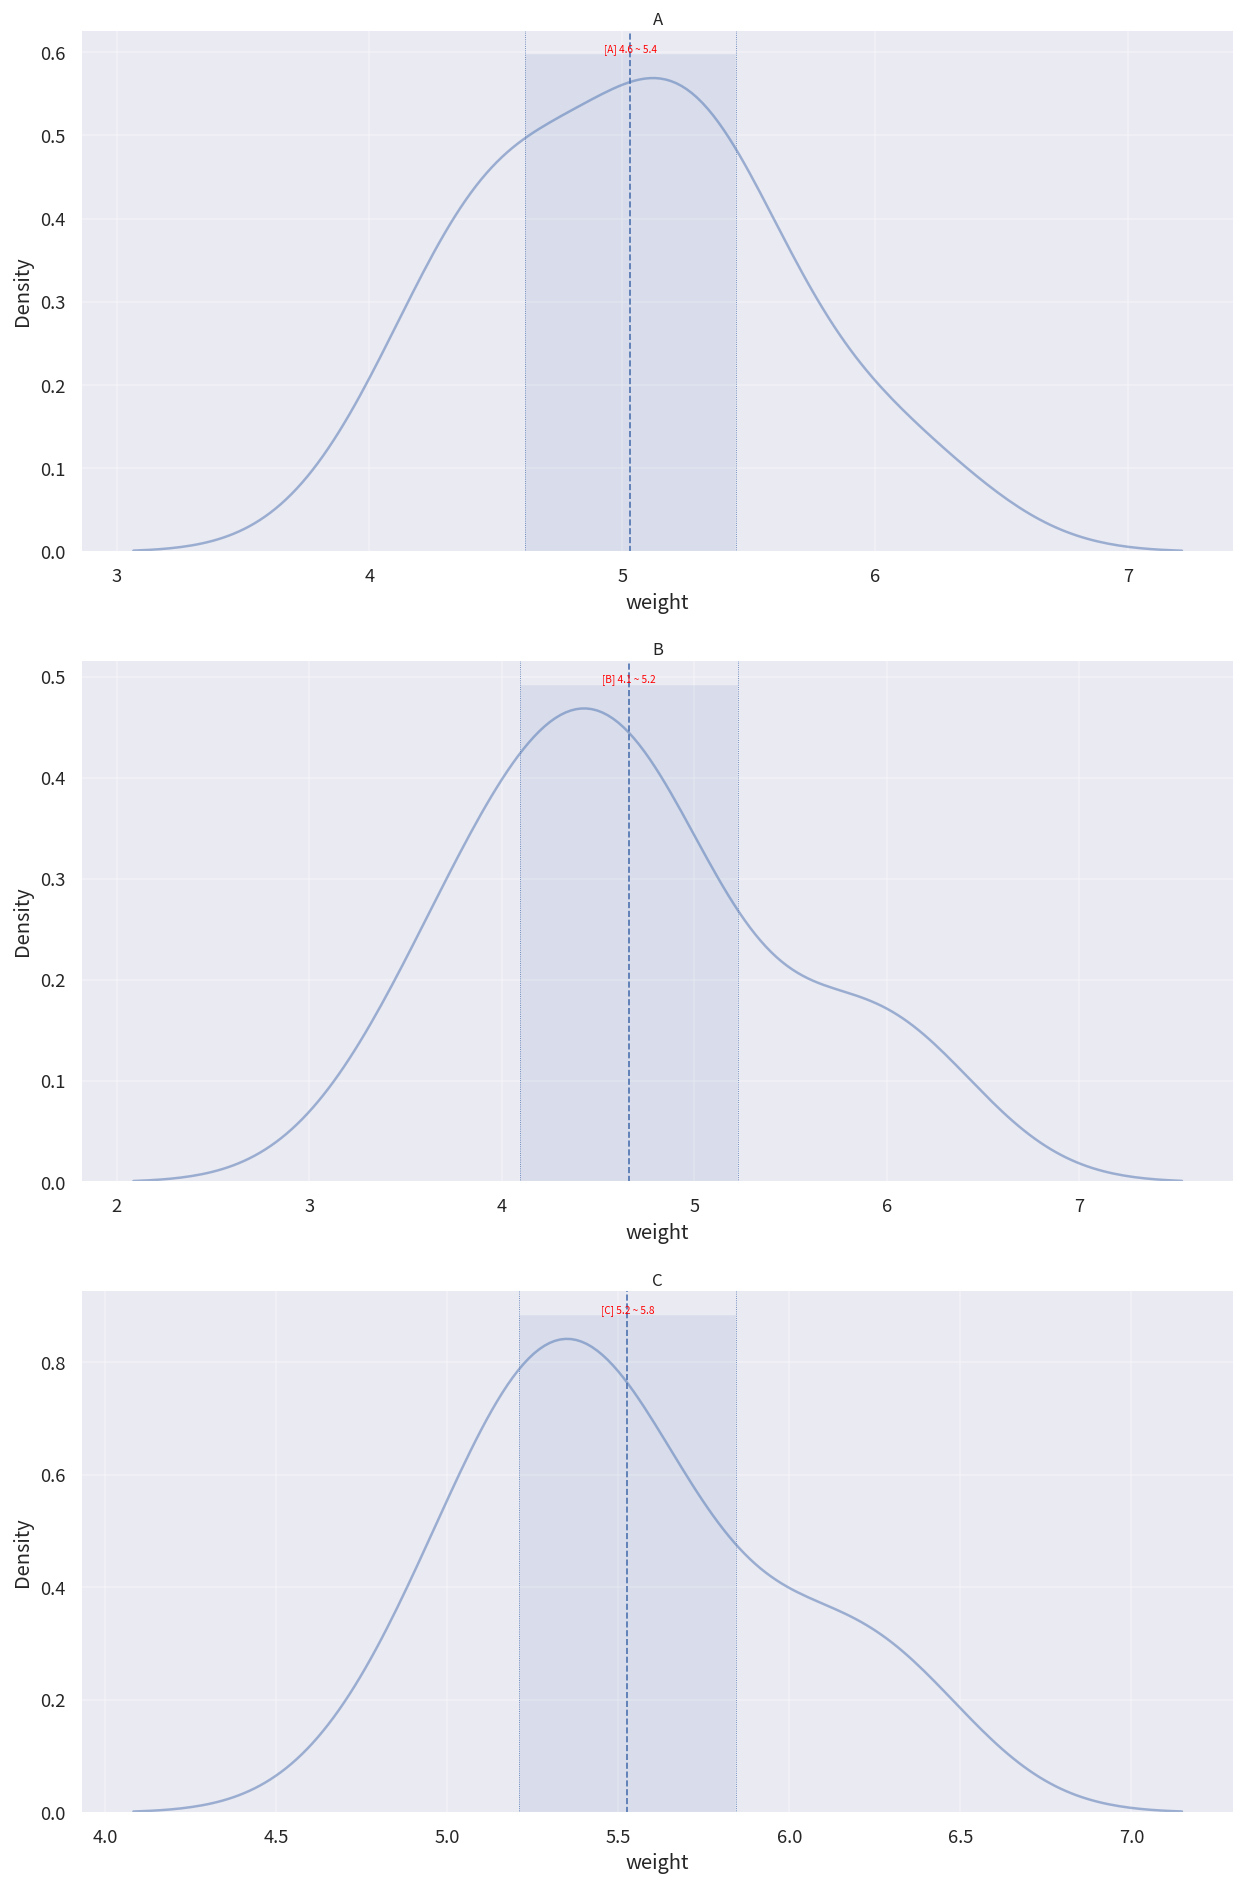

In [5]:
# 확인할 데이터 필드
field = 'weight'

# 집단을 구분하는 필드(hue)
hue_field = 'group'

# 요일 종류 구하기
hue_values = tree_weight[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 3              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = tree_weight[tree_weight[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


<인사이트>


[2] 정규성, 등분산성 검정

In [7]:
# 요일별 그룹 생성
groups = [(name, grp['weight']) for name, grp in tree_weight.groupby('group')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
Bartlett,2.878574,0.237097,True


[3] 일원분산분석 수행

In [8]:
if equal_var :
  pg_anova = anova (data = tree_weight , dv='weight',between ='group')

else :
  pg_anova = welch_anova(data = tree_weight , dv = 'weight' , between ='group')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


In [10]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

<인사이트>
세 집단 A,B,C 간의 평균 나무 무게의 차이를 검정한 결과, 유의수준 0.05 기준에서 통계적으로 유의한 차이가 확인되었다 (P = 0.016)

[4] 사후검정


In [14]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=tree_weight, dv='weight', between='group')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(tree_weight, dv='weight', between='group')
hoc_df


=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


<인사이트>
- 집단 B 와 C 가 p-tukey 0.012 로 나타나 평균 나무 무게의 유의한 차이가 확인되었다 

## 연습문제 2 
reading 데이터셋은 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수데이터이다.

세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

[0] 데이터 불러오기

In [17]:
reading = load_data('reading')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {reading.shape}")
print(f"열 개수: {reading.shape[1]}")
print(f"행 개수: {reading.shape[0]}")

print("\n===== 타입확인 =====")
print(reading.info())

reading


[data] https://data.hossam.kr/data/lab10_/reading.xlsx
[desc] 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90, 2)
열 개수: 2
행 개수: 90

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   독서방법    90 non-null     object 
 1   점수      90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB
None


,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3
...,...,...
85,G,13.6
86,G,18.4
87,G,17.0
88,G,11.7


[1] 데이터 분포 확인

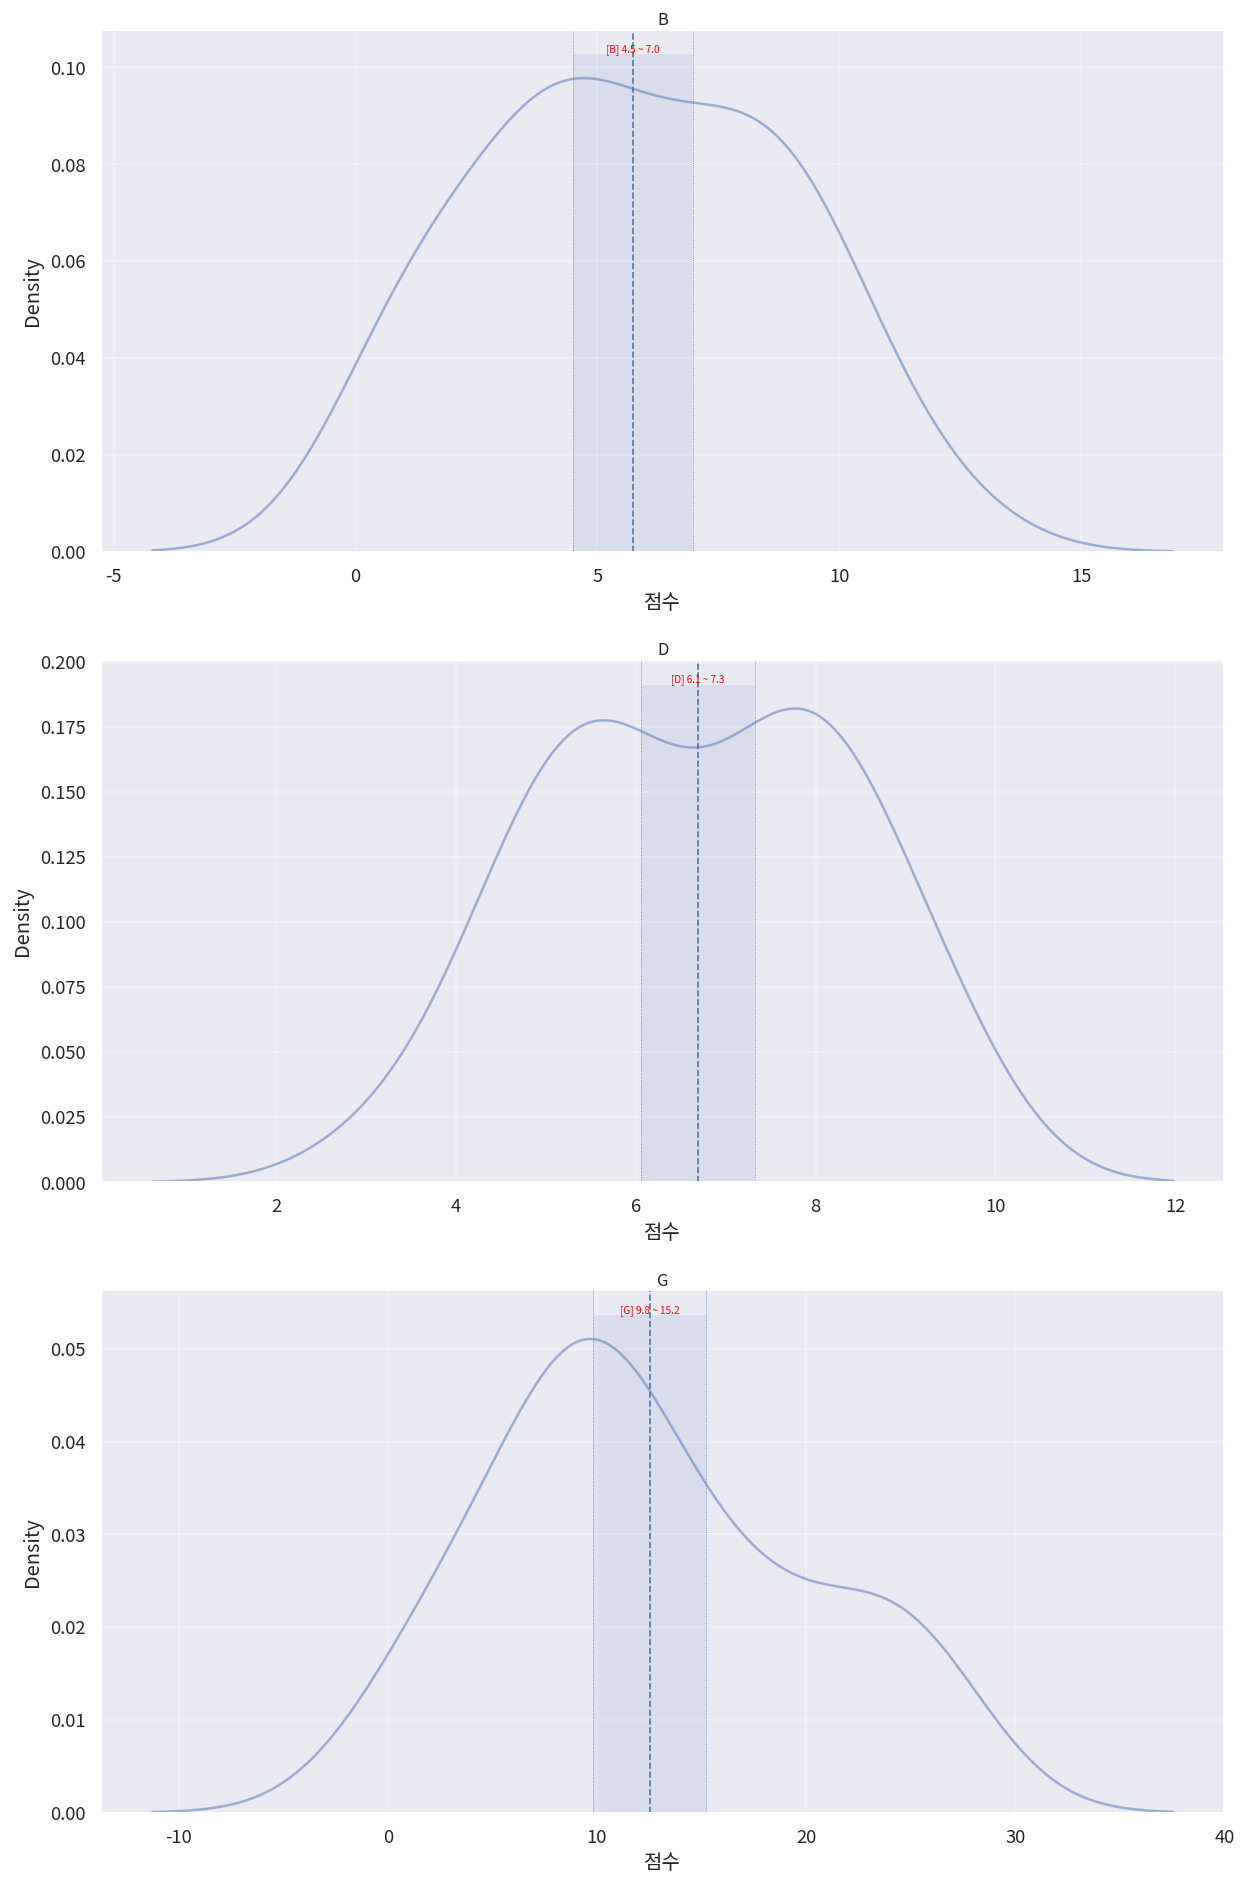

In [16]:
# 확인할 데이터 필드
field = '점수'

# 집단을 구분하는 필드(hue)
hue_field = '독서방법'

# 요일 종류 구하기
hue_values = reading[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 3              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = reading[reading[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


[2] 정규성, 등분산성 검정

In [19]:
# 요일별 그룹 생성
groups = [(name, grp['점수']) for name, grp in reading.groupby('독서방법')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
B,2.210100,3.311943e-01,True
D,2.396634,3.017015e-01,True
G,2.216900,3.300701e-01,True
Bartlett,58.099241,2.420528e-13,False


[3] pingouin 패키지 사용

In [21]:
if equal_var :
  pg_anova = anova (data = reading , dv='점수',between ='독서방법')

else :
  pg_anova = welch_anova(data = reading , dv = '점수' , between ='독서방법')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


In [22]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 10.787, p-value: 0.000, 대립가설 채택'

[3] 사후검정

In [23]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=reading, dv='점수', between='독서방법')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(reading, dv='점수', between='독서방법')
hoc_df


=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,B,D,5.732143,6.693333,-0.961190,0.676594,-1.420631,40.563109,0.339976,-0.375556
1,B,G,5.732143,12.531250,-6.799107,1.457054,-4.666340,42.964012,0.000088,-1.136960
2,D,G,6.693333,12.531250,-5.837917,1.362766,-4.283874,34.360873,0.000403,-1.043650


-B 와 G / D 와 G 의 독서방법 점수의 평균에 유의미한 차이가 확인되었다

## 연습문제 3 
commercial 데이터셋 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.

서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.

상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.

주어진 데이터는 서울시에서 제공하는 집계가 완료된 데이터이므로 모든 결측치는 없는 상태이며 이상치도 실제 매출액 데이터이므로 별도의 정제 과정 없이 진행하는 것으로 한다

[1] 데이터 불러오기

In [25]:
commercial = load_data('commercial')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {commercial.shape}")
print(f"열 개수: {commercial.shape[1]}")
print(f"행 개수: {commercial.shape[0]}")

print("\n===== 타입확인 =====")
print(commercial.info())

commercial.head()


[data] https://data.hossam.kr/data/lab10_/commercial.xlsx
[desc] 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료 (출처: 서울 열린데이터 광장)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (6222, 6)
열 개수: 6
행 개수: 6222

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   quarter          6222 non-null   int64 
 1   code             6222 non-null   int64 
 2   type             6222 non-null   object
 3   name             6222 non-null   object
 4   sales_amount     6222 non-null   int64 
 5   number_of_sales  6222 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 291.8+ KB
None


,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


[2] 데이터 분포 확인

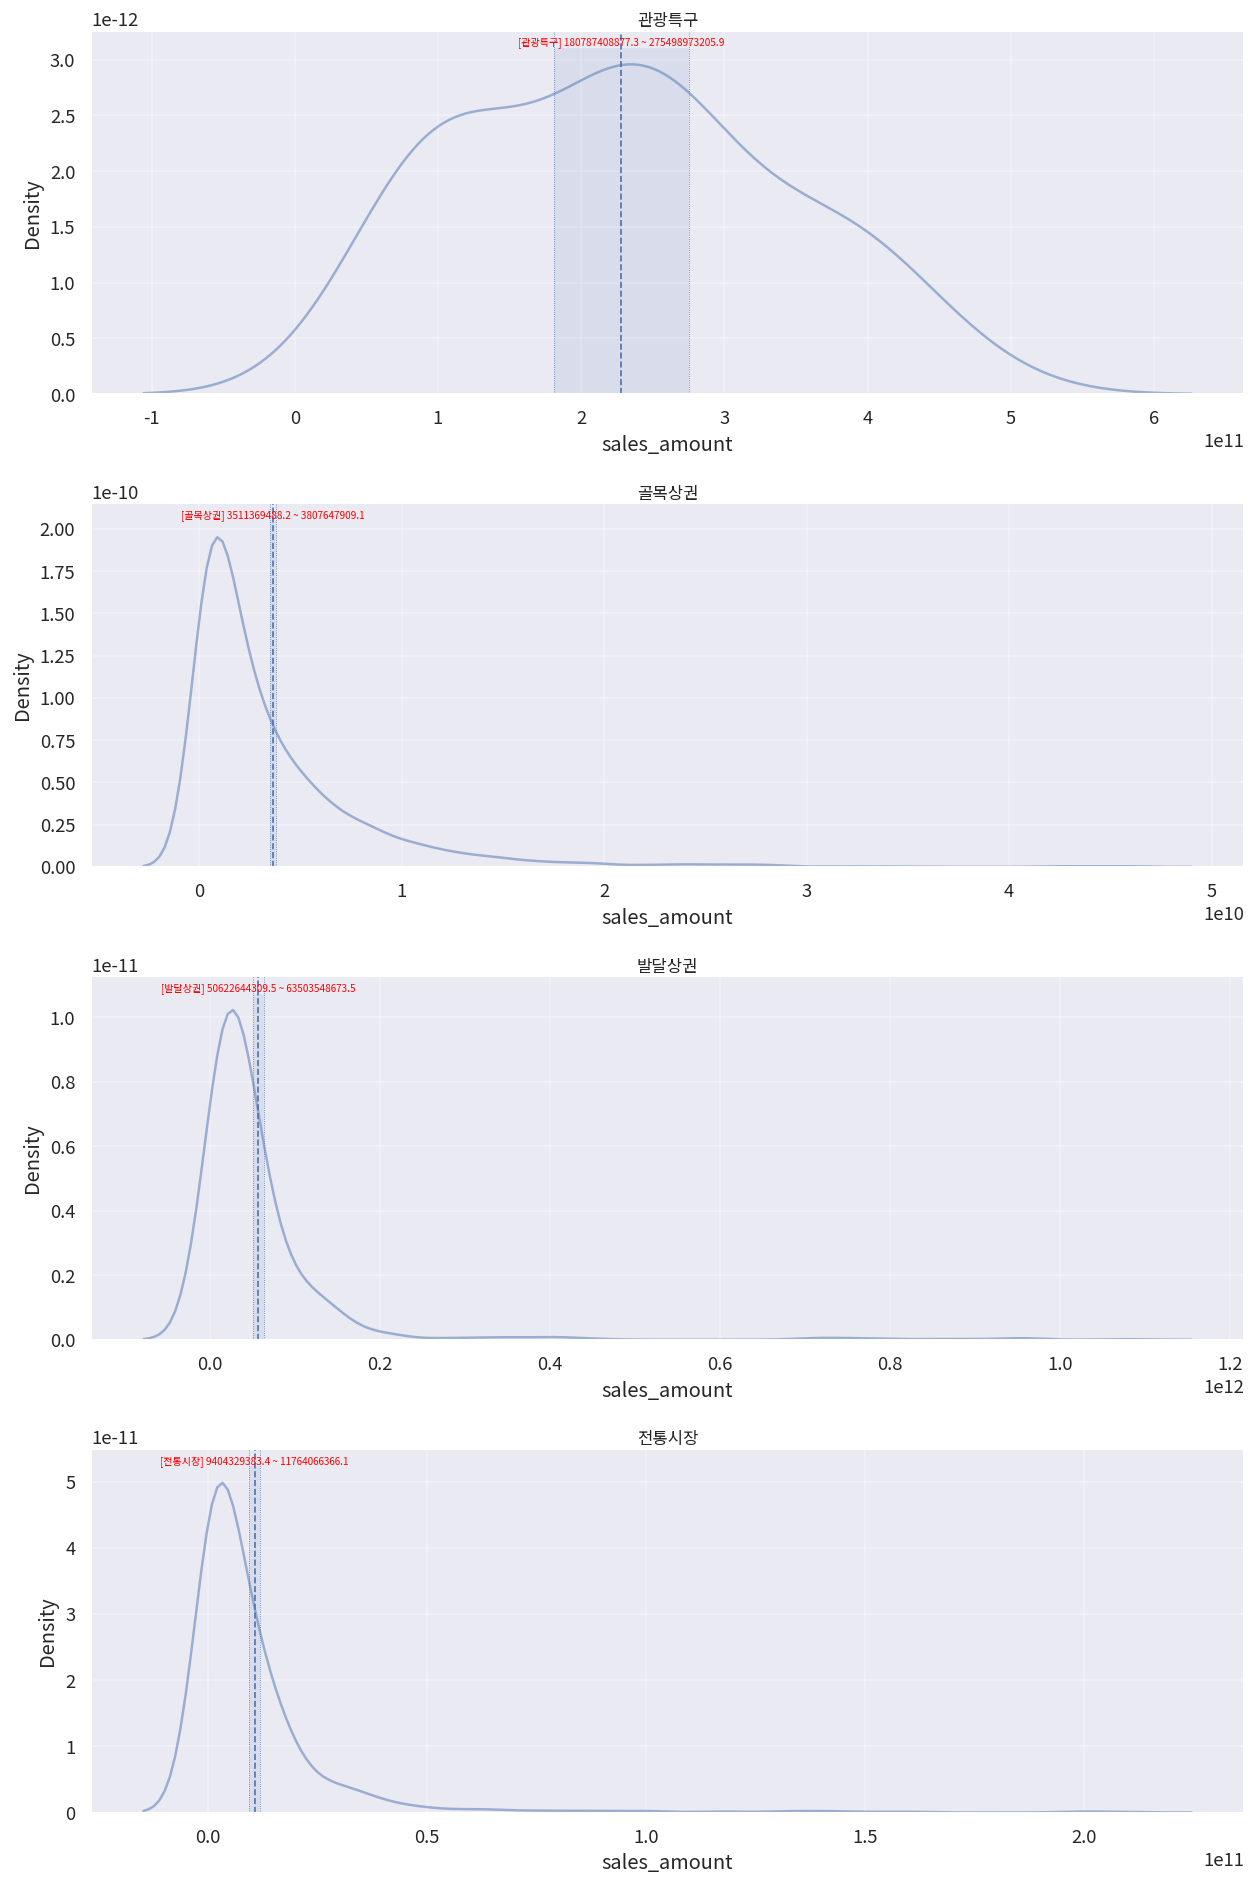

In [28]:
# 확인할 데이터 필드
field = 'sales_amount'

# 집단을 구분하는 필드(hue)
hue_field = 'type'

# 요일 종류 구하기
hue_values = commercial[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 4              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = commercial[commercial[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


[3] 정규성 등분산성 확인

In [29]:
# 요일별 그룹 생성
groups = [(name, grp['sales_amount']) for name, grp in commercial.groupby('type')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
골목상권,2949.769498,0.000000e+00,False
관광특구,2.023450,3.635912e-01,True
발달상권,1174.363632,9.776365e-256,False
전통시장,1194.779826,3.604601e-260,False
Levene,268.725277,5.300718e-164,False


In [30]:
if equal_var :
  pg_anova = anova (data = commercial   , dv='sales_amount',between ='type')

else :
  pg_anova = welch_anova(data = commercial   , dv = 'sales_amount' , between ='type')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,type,3,110.238825,161.432719,3.495920e-40,0.228001


In [31]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 161.433, p-value: 0.000, 대립가설 채택'

In [32]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=commercial  , dv='sales_amount', between='type')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(commercial  , dv='sales_amount', between='type')
hoc_df


=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509e+09,2.281432e+11,-2.244837e+11,2.289216e+10,-9.806138,23.000501,6.410146e-09,-23.206979
1,골목상권,발달상권,3.659509e+09,5.706310e+10,-5.340359e+10,3.282878e+09,-16.267309,996.054989,7.271961e-14,-1.160433
2,골목상권,전통시장,3.659509e+09,1.058420e+10,-6.924689e+09,6.060559e+08,-11.425826,1143.188337,0.000000e+00,-0.679464
3,관광특구,발달상권,2.281432e+11,5.706310e+10,1.710801e+11,2.312611e+10,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,2.281432e+11,1.058420e+10,2.175590e+11,2.289993e+10,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,5.706310e+10,1.058420e+10,4.647890e+10,3.336641e+09,13.929848,1061.849622,3.926859e-13,0.638976
